# Exploring the Relationship Between Police Stops and Crime in San Diego: A Microgeographic Analysis of Demographic Factors and Policing Strategies

In recent years, the effectiveness and implications of police stops have been at the center of public debate and academic inquiry. This study aims to contribute to the ongoing discourse by examining the relationship between police stops and crime in San Diego at a microgeographic level. By focusing on regional variations, demographic factors, and community impact, we seek to provide valuable insights into the efficiency and consequences of police stops within the city's diverse police beats. Through a comprehensive analysis of crime patterns and outcomes, our research aims to inform evidence-based recommendations for refining and improving policing strategies in San Diego and other similar urban areas, ultimately fostering more equitable and effective law enforcement practices.

In examining the relationship between police stops and crime, it is important to consider the existing literature on this subject. Miller et al. (2000) found that while stops and searches play some role in fighting crime and lead to about one-tenth of arrests nationally, they have only a small impact on the detection and prevention of recorded or reported crime. Additionally, searches tend to have a negative impact on public confidence in the police, often due to perceived impoliteness and inadequate explanations for stopping individuals. The authors recommend focusing on efficient and targeted use of searches based on intelligence and high levels of suspicion while emphasizing more serious crimes and prolific offenders.

MacDonald et al. (2016) investigated the effects of the New York Police Department's (NYPD) Operation Impact, which deployed extra police officers to high crime areas. The authors found that impact zones were associated with significant reductions in reported crimes and increases in reported arrests. However, they also noted that the majority of investigative stops did not play an important role in crime reduction, suggesting that more focused investigative stops could be more effective.

Weisburd et al. (2015) explored the impact of stop, question, and frisks (SQFs) on crime in New York City at a microgeographic level. They found that SQFs produce a significant yet modest deterrent effect on crime but questioned whether other policing strategies might yield similar or stronger crime-control outcomes. They also noted that the level of SQFs needed to achieve meaningful crime reductions can be costly and potentially harmful to police legitimacy.

Petersen et al. (2023) conducted a systematic review and meta-analysis on the effects of police-initiated pedestrian stops on crime and individual-level outcomes. Their findings indicated that pedestrian stop interventions were associated with a statistically significant reduction in crime for treatment areas relative to control areas. However, they also found that such interventions led to a broad range of negative individual-level effects, such as increased odds of mental and physical health issues, more negative attitudes toward the police, and higher levels of self-reported crime and delinquency. The authors concluded that, although pedestrian stop interventions have favorable effects on place-based crime and displacement outcomes, the negative individual-level effects make it difficult to recommend their use over alternative policing interventions.

A recent news article by Moran, Winkley, and Schroeder (2022) provides additional context for our study, highlighting disparities in police stops within San Diego. Their analysis revealed that police in San Diego conduct more traffic and pedestrian stops per reported crime in areas where non-Whites make up the majority of the population. While police officials attribute the disparity in enforcement to factors other than racial bias, the analysis suggests that some communities experience a level of enforcement that cannot simply be explained by crime rates. However, the article does not quantify or measure the relationship between stops and crimes, nor does it directly answer the question, "Are stops happening where crime is happening?" Instead, the authors primarily rely on descriptive statistics.

Building upon the findings of Moran et al. (2022) and the previous literature, our study aims to fill this gap by quantifying the relationship between the number of stops and the number of crimes withinSan Diego's police beats. This localized focus allows us to compare different areas with varying levels of crime and stops, providing insights that can be used to improve policing strategies. Furthermore, our research will assess the efficiency of police stops in San Diego and explore how well they align with crime levels across different police beats. Focusing on demographic factors, our study will investigate the role of variables such as race and gender in the relationship between police stops and crime in San Diego. By examining how these factors may influence the patterns and outcomes of stops, we aim to contribute to a deeper understanding of the impact of police practices on different communities and support the development of more equitable policing strategies. In summary, our study on the relationship between police stops and crime in San Diego will complement and extend the existing literature, offering valuable insights that contribute to a deeper understanding of this relationship and providing evidence-based recommendations for refining and improving policing strategies in San Diego and other similar cities.

### Data Prep

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from stargazer.stargazer import Stargazer

c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Read the crime data
"""
Crime Data has the following columns:
    ['activityNumber', 'activityType', 'activityDate', 'Year',
       'violationSection', 'violationType', 'chargeDescription', 'codeUcr',
       'BlockNumber', 'streetDirection', 'streetName', 'streetType', 'city',
       'state', 'zipCode', 'beat']
"""
crime_data = pd.read_excel('PRA 21-4922_2019-2021_Crimes__UCR Revised.xlsx')

# read the stop data
"""
Stop Data has the following columns:
    ['Unnamed: 0', 'stop_id', 'pid', 'id', 'ori', 'agency', 'exp_years',
       'date', 'time', 'dur', 'is_serv', 'assign_key', 'assign_words',
       'inters', 'block', 'ldmk', 'street', 'hw_exit', 'is_school',
       'school_name', 'city', 'beat', 'beat_name', 'is_student', 'lim_eng',
       'age', 'gender_words', 'is_gendnc', 'gender_code', 'gendnc_code',
       'lgbt', 'race', 'disability', 'reason_words', 'reasonid', 'reason_text',
       'reason_detail', 'reason_exp', 'search_basis', 'search_basis_exp',
       'seiz_basis', 'prop_type', 'cont', 'actions', 'act_consent']
"""
stops_2019 = pd.read_csv('master-ripa-2019.csv')
stops_2020 = pd.read_csv('master-ripa-2020.csv')
stops_2021 = pd.read_csv('master-ripa-2021.csv')

# read the beat demographics data
"""
Beat Demographics Data has the following columns:
    ['beat', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']
"""
beat_demographics = pd.read_csv('beat_demographics_2019_acs.csv')

c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (15,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Combine stops data from 2019, 2020, and 2021
stops_data = pd.concat([stops_2019, stops_2020, stops_2021])

Fix Race Labels in the stop data

In [4]:
# print number of unique race values
print(len(stops_data["race"].unique()))

146


In [4]:
# convert race to string typ
stops_data["race"] = stops_data["race"].astype(str)

In [6]:
len(stops_data["race"].unique())

146

In [5]:
# print first 5 instances of race
stops_data["race"].head()

0          Hispanic/Latino/a
1                      White
2    Hispanic/Latino/a|White
3          Hispanic/Latino/a
4     Black/African American
Name: race, dtype: object

In [6]:
# check if the first 5 have "|" in them
stops_data["race"][0:5].str.contains('\\|', regex=True).sum()

1

In [7]:
multiracial_count = stops_data['race'].str.contains('\\|', regex=True).sum()
total_count = len(stops_data)
print(f"Multiracial count: {multiracial_count} out of {total_count} ({100 * multiracial_count / total_count:.2f}%)")

Multiracial count: 3767 out of 407684 (0.92%)


In [8]:
# count the unique values in the race column that do not contain '\\|'
stops_data["race"][~stops_data["race"].str.contains('\\|', regex=True)].value_counts()

White                            168446
Hispanic/Latino/a                119515
Black/African American            81387
Asian                             19647
Middle Eastern or South Asian     11001
Pacific Islander                   3112
Native American                     809
Name: race, dtype: int64

In [9]:
def simplify_race(race):
    if 'White' in race:
        return 'white'
    elif 'Black/African American' in race:
        return 'black'
    elif 'Asian' in race:
        return 'asian'
    elif 'Hispanic/Latino/a' in race:
        return 'hisp'
    elif 'Native American' in race:
        # https://www.census.gov/programs-surveys/acs/data/race-aian.html
        return 'aian'
    elif 'Pacific Islander' in race:
        return 'nhopi'
    elif 'Middle Eastern or South Asian' in race:
        return 'other'
    else:
        return 'other'

In [10]:
# apply the simplify_race function to the race column
stops_data["race"] = stops_data["race"].apply(simplify_race)

In [28]:
stops_data.head()

,Unnamed: 0,stop_id,pid,id,ori,agency,exp_years,date,time,dur,...,reason_text,reason_detail,reason_exp,search_basis,search_basis_exp,seiz_basis,prop_type,cont,actions,act_consent
0,1,84362,1,84362_1,CA0371100,SD,10,2019-01-01,00:15:07,30,...,27150(A) VC - INADEQUATE MUFFLERS (I) 54116,Equipment Violation,LOUD EXHAUST,Vehicle inventory,IMPOUNDED,NaN,NaN,None,Search of property was conducted|Vehicle impou...,NA|NA
1,2,84364,1,84364_1,CA0371100,SD,2,2019-01-01,00:15:16,10,...,415(2) PC - LOUD/UNREASONABLE NOISE (I) 53130,Officer witnessed commission of a crime,loud party,NaN,NaN,NaN,NaN,None,Curbside detention,NaN
2,3,84365,1,84365_1,CA0371100,SD,1,2019-01-01,00:02:00,5,...,647(F) PC - DISORD CONDUCT:ALCOHOL (M) 64005,Officer witnessed commission of a crime,"stumbling back and forth, unable to maintain b...",Incident to arrest,search incident to arrest,NaN,NaN,None,Patrol car detention|Handcuffed or flex cuffed...,NA|NA|NA
3,4,84366,1,84366_1,CA0371100,SD,1,2019-01-01,00:38:00,5,...,647(F) PC - DISORD CONDUCT:ALCOHOL (M) 64005,Officer witnessed commission of a crime,fighting with security,Incident to arrest,search incident to arrest,NaN,NaN,None,Curbside detention|Handcuffed or flex cuffed|S...,NA|NA|NA
4,5,84369,1,84369_1,CA0371100,SD,17,2019-01-01,01:06:41,2,...,602 PC - TRESPASSING (M) 32022,Matched suspect description,rc of male at vacant house,NaN,NaN,NaN,NaN,None,None,NaN


Add other race to demographic data

In [11]:
beat_demographics['other'] = beat_demographics['total'] - (
    beat_demographics['white'] + 
    beat_demographics['black'] + 
    beat_demographics['aian'] + 
    beat_demographics['asian'] + 
    beat_demographics['nhopi'] + 
    beat_demographics['hisp']
)

In [12]:
# Group crime and stops data by beat
crime_by_beat = crime_data.groupby('beat').size().reset_index(name='num_crimes')
stops_by_beat = stops_data.groupby(['beat', 'race']).size().reset_index(name='num_stops')

# Merge crime and stops data by beat
crime_stops_by_beat = pd.merge(crime_by_beat, stops_by_beat, on='beat')

# Merge crime_stops_by_beat with beat_demographics
crime_stops_demographics_by_beat = pd.merge(crime_stops_by_beat, beat_demographics, on='beat')

# Calculate the ratio of stops to crimes in each beat
crime_stops_demographics_by_beat['stops_to_crimes_ratio'] = crime_stops_demographics_by_beat['num_stops'] / crime_stops_demographics_by_beat['num_crimes']

# Calculate the proportion of stops for each racial group in each beat
racial_groups = ['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']
for group in racial_groups:
    crime_stops_demographics_by_beat[f'{group}_stops_proportion'] = crime_stops_demographics_by_beat.loc[crime_stops_demographics_by_beat['race'] == group, 'num_stops'] / crime_stops_demographics_by_beat[group]

In [31]:
# Display the results
print(crime_stops_demographics_by_beat.sort_values(by='stops_to_crimes_ratio', ascending=False))

     beat  num_crimes   race  num_stops  total  white  black  aian  asian  \
26  316.0          36  other        451   1163    691     57     3    102   
88  714.0         231  other       1618    194      4      5     0      6   
38  435.0          39  other        263    395     89     67     2     21   
54  514.0         503  other       3339   2919    634    139     8     50   
85  711.0          33  other        196   8205    482    243     0    397   
..    ...         ...    ...        ...    ...    ...    ...   ...    ...   
82  626.0         788  other        868   5815   4462     69     9    283   
31  325.0         609  other        668  11951   8264    432    28    917   
95  812.0          64  other         67   1030    701     36     0     61   
20  246.0         330  other        344  15614   7205    327    18   5276   
16  241.0         775  other        739  20300  12367    605    51   3616   

    nhopi  hisp  other  stops_to_crimes_ratio  white_stops_proportion  \
26

In [32]:
# print the data for beat 316
crime_stops_demographics_by_beat[crime_stops_demographics_by_beat['beat'] == 935]

,beat,num_crimes,race,num_stops,total,white,black,aian,asian,nhopi,hisp,other,stops_to_crimes_ratio,white_stops_proportion,black_stops_proportion,aian_stops_proportion,asian_stops_proportion,nhopi_stops_proportion,hisp_stops_proportion,other_stops_proportion
121,935.0,251,other,691,9513,5535,25,6,2731,16,706,494,2.752988,NaN,NaN,NaN,NaN,NaN,NaN,1.398785


### Simple Analysis

In [13]:
# group num_stops by beat and num_crimes and drop the race column only keep beat, num_crimes, and num_stops
model1_data = crime_stops_by_beat.groupby(['beat', 'num_crimes']).sum().reset_index()

# since the data is for three years, divide num_stops and num_crimes by 3 to get the average number of stops per year
model1_data['num_stops'] = model1_data['num_stops'] / 3
model1_data['num_crimes'] = model1_data['num_crimes'] / 3

# add the column "total" from beat_demographics to model1_data and join on "beat"
model1_data = pd.merge(model1_data, beat_demographics[['beat', 'total','white', 'black', 'aian', 'asian', 'nhopi', 'hisp',
       'other']], on='beat')

# add a binary column majority_white to model1_data if white/total > 0.5
model1_data['majority_white'] = (model1_data['white'] / model1_data['total'] > 0.5).astype(int)
model1_data['pct_non_white'] = 1-(model1_data['white'] / model1_data['total'] )


In [14]:
# create a new column that converst num_crimes to percentiles
model1_data['num_crimes_percentile'] = model1_data['num_crimes'].rank(pct=True)

# create a new column that converst num_stops to percentiles
model1_data['num_stops_percentile'] = model1_data['num_stops'].rank(pct=True)

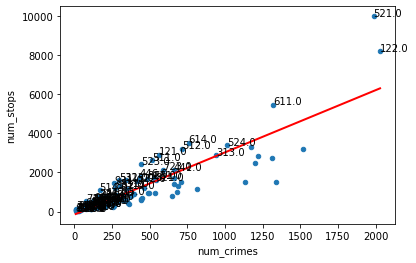

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

above_average_beats = []
# Fit a linear regression model
X = model1_data[['num_crimes']]
y = model1_data['num_stops']
reg = LinearRegression().fit(X, y)

# Plot the scatter plot
ax = model1_data.plot.scatter(x='num_crimes', y='num_stops')

# Plot the best fit line
x_values = np.linspace(model1_data['num_crimes'].min(), model1_data['num_crimes'].max(), 100)
y_values = reg.predict(x_values.reshape(-1, 1))
ax.plot(x_values, y_values, color='red', linewidth=2)

# Label points above the best fit line using the "beat" column
for index, row in model1_data.iterrows():
    predicted_stops = reg.predict([[row['num_crimes']]])
    if row['num_stops'] > predicted_stops:
        ax.annotate(row['beat'], (row['num_crimes'], row['num_stops']))
        above_average_beats.append(row['beat'])

#set plot size
plt.rcParams['figure.figsize'] = [30, 15]

# Show the plot
plt.show()

<AxesSubplot: xlabel='num_stops_percentile', ylabel='num_crimes_percentile'>

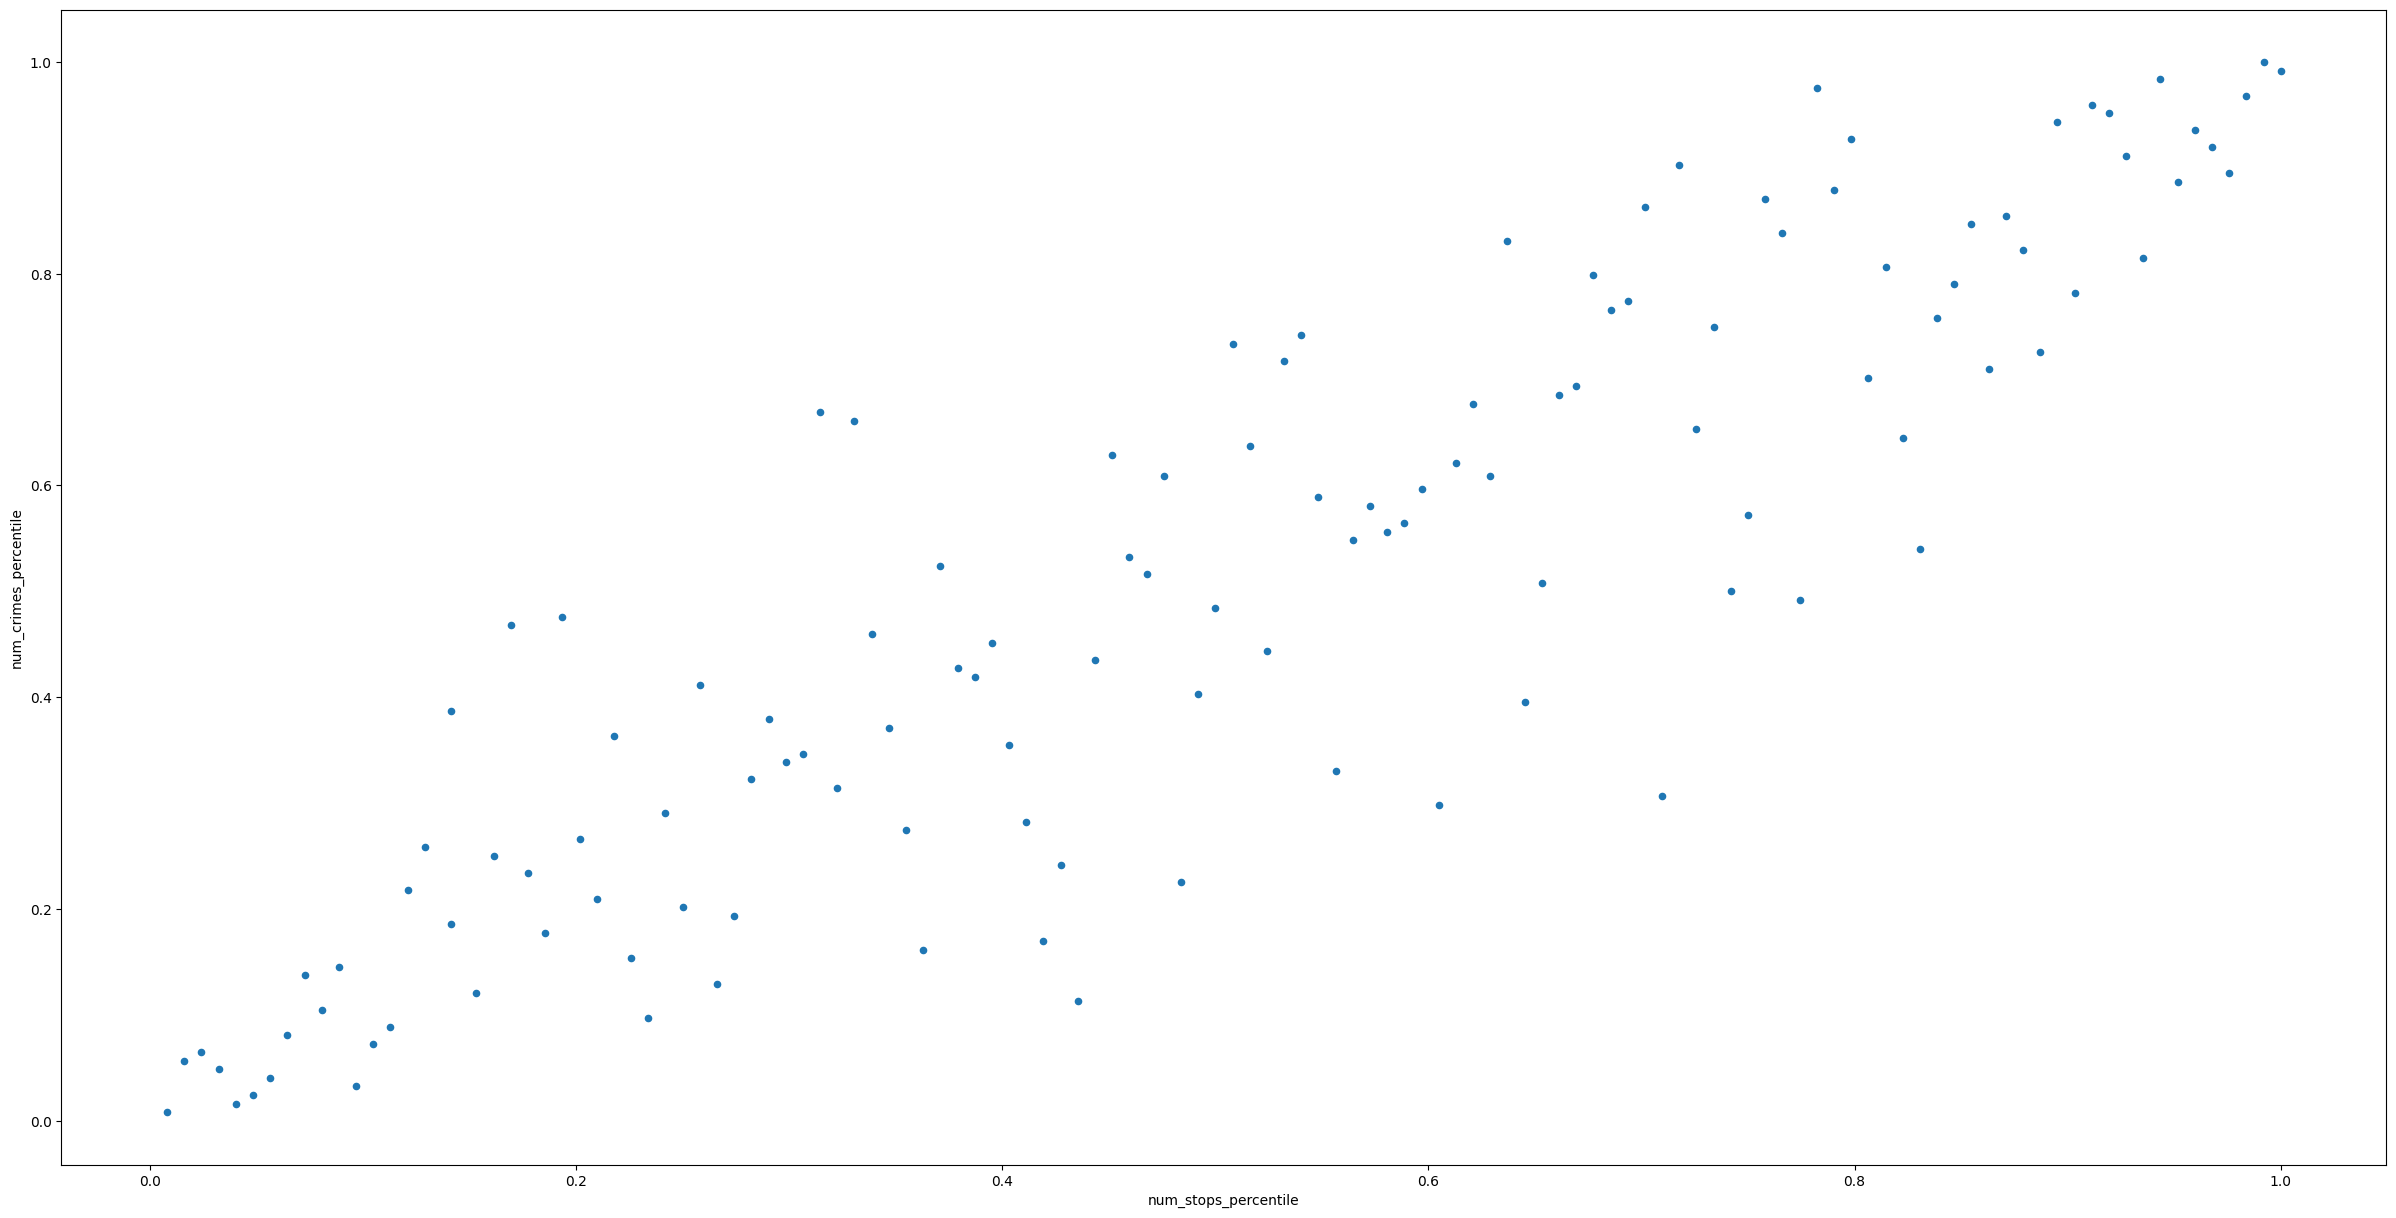

In [36]:
# plot a scatter plot of num_stops_percentile and num_crimes_percentile
model1_data.plot.scatter(x='num_stops_percentile', y='num_crimes_percentile')

Regression with the number of stops as the dependent variable and the number of crimes as the independent variable:


In [42]:
model1_linear = smf.ols(formula='num_stops~num_crimes', data=model1_data).fit()
print(model1_linear.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     376.1
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           4.48e-39
Time:                        00:13:56   Log-Likelihood:                -985.73
No. Observations:                 124   AIC:                             1975.
Df Residuals:                     122   BIC:                             1981.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -155.3516     88.588     -1.754      0.0

In [49]:
model1_linear_race = smf.ols(formula=' num_stops ~ num_crimes + pct_non_white', data=model1_data).fit()
print(model1_linear_race.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     188.7
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           6.39e-38
Time:                        00:22:09   Log-Likelihood:                -985.18
No. Observations:                 124   AIC:                             1976.
Df Residuals:                     121   BIC:                             1985.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -322.4175    183.482     -1.757

In [39]:
# build a linear regression model using percentiles
model1_linear_percentile= smf.ols(formula='num_crimes_percentile ~ num_stops_percentile', data=model1_data).fit()
print(model1_linear_percentile.summary())

                              OLS Regression Results                             
Dep. Variable:     num_crimes_percentile   R-squared:                       0.794
Model:                               OLS   Adj. R-squared:                  0.792
Method:                    Least Squares   F-statistic:                     470.4
Date:                   Fri, 28 Apr 2023   Prob (F-statistic):           1.11e-43
Time:                           17:45:33   Log-Likelihood:                 76.094
No. Observations:                    124   AIC:                            -148.2
Df Residuals:                        122   BIC:                            -142.5
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
In

In [40]:
# run a poisson regression model using num_stops and num_crimes with a population as the offset
model1_poisson = smf.poisson(formula='num_stops ~ num_crimes', data=model1_data, offset=np.log(model1_data['total'])).fit()
print(model1_poisson.summary())

Optimization terminated successfully.
         Current function value: 578.043177
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:              num_stops   No. Observations:                  124
Model:                        Poisson   Df Residuals:                      122
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Apr 2023   Pseudo R-squ.:                  0.1190
Time:                        17:45:34   Log-Likelihood:                -71677.
converged:                       True   LL-Null:                       -81361.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8427      0.005   -596.846      0.000      -2.852      -2.833
num_crimes     0.0007   4.8

In [41]:
# use stargazer to compare the results of the linear regression and poisson regression models
from sklearn.metrics import mean_squared_error

stargazer = Stargazer([model1_linear, model1_linear_race])
#stargazer.covariate_order(['Intercept', 'num_stops'])
stargazer.rename_covariates({'Intercept': 'Constant', 'num_crimes': 'Crimes', 'pct_non_white': 'Pct. Non-White'})
stargazer.custom_columns(["Linear", "Linear with Race"], [1, 1])
stargazer.title('Linear vs. Linear w/Race')

presentation_output = stargazer.render_html()


with open("presentation_results_table2.html", "w") as file:
    file.write(presentation_output)

In [42]:
stargazer = Stargazer([model1_linear, model1_poisson])
stargazer.covariate_order(['Intercept', 'num_stops'])
stargazer.rename_covariates({'Intercept': 'Constant', 'num_stops': 'Stops'})
stargazer.custom_columns(["Linear", "Poisson"], [1, 1])
stargazer.title('Model 1: Linear vs. Poisson Regression')
rmse_poisson = np.sqrt(np.mean((model1_data['num_crimes'] - model1_poisson.predict())**2))
rmse_linear = np.sqrt(np.mean((model1_data['num_crimes'] - model1_linear.predict())**2))
# stargazer.add_line('RMSE', [f'{rmse_poisson:.4f}', f'{rmse_linear:.4f}'])

presentation_output = stargazer.render_html()


with open("presentation_results_table.html", "w") as file:
    file.write(presentation_output)

# Read the contents of the HTML file
with open("presentation_results_table.html", "r") as file:
    table_html = file.read()

# Find the position to insert a new row
insert_pos = table_html.find('</tr>', table_html.find('<tr>') + 12) + len('</tr>')

# Create a new row with the MSE values
new_row = f'\n<tr><td>MSE</td><td>{rmse_linear:.4f}</td><td>{rmse_poisson:.4f}</td></tr>'

# Insert the new row after row 5 in the HTML table
modified_table_html = table_html[:insert_pos] + new_row + table_html[insert_pos:]

# Save the modified contents back to the HTML file
with open("presentation_results_table.html", "w") as file:
    file.write(modified_table_html)


AssertionError: Covariate order must contain subset of existing covariates: {'num_stops'} are not.

Regression including demographic variables

In [43]:
# group by crime_stops_demographics_by_beat by beat	num_crimes	num_stops	total	white	black	aian	asian	nhopi	hisp	other
model2_data = crime_stops_demographics_by_beat.groupby(['beat', 'num_crimes', 'num_stops', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']).sum().reset_index()

/var/folders/71/wmk9vs213tlg98b354gxvj4m0000gn/T/ipykernel_46384/3945456627.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model2_data = crime_stops_demographics_by_beat.groupby(['beat', 'num_crimes', 'num_stops', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']).sum().reset_index()


In [44]:
crime_stops_demographics_by_beat.tail()

,beat,num_crimes,race,num_stops,total,white,black,aian,asian,nhopi,hisp,other,stops_to_crimes_ratio,white_stops_proportion,black_stops_proportion,aian_stops_proportion,asian_stops_proportion,nhopi_stops_proportion,hisp_stops_proportion,other_stops_proportion
119,933.0,399,other,1784,7391,5722,136,0,821,19,360,333,4.471178,NaN,NaN,NaN,NaN,NaN,NaN,5.357357
120,934.0,1980,other,5119,45788,25358,428,177,13754,12,4013,2046,2.585354,NaN,NaN,NaN,NaN,NaN,NaN,2.501955
121,935.0,251,other,691,9513,5535,25,6,2731,16,706,494,2.752988,NaN,NaN,NaN,NaN,NaN,NaN,1.398785
122,936.0,229,other,393,7762,3479,102,63,2777,30,808,503,1.716157,NaN,NaN,NaN,NaN,NaN,NaN,0.781312
123,937.0,377,other,1047,9451,5558,113,49,2568,0,763,400,2.777188,NaN,NaN,NaN,NaN,NaN,NaN,2.617500


In [45]:
model2 = smf.poisson("num_stops ~ num_crimes + white + black + hisp + aian +asian + hisp+ other", data=model2_data).fit(maxiter=1000)
print(model2.summary())


Optimization terminated successfully.
         Current function value: 372.255088
         Iterations 76
                          Poisson Regression Results                          
Dep. Variable:              num_stops   No. Observations:                  124
Model:                        Poisson   Df Residuals:                      116
Method:                           MLE   Df Model:                            7
Date:                Fri, 28 Apr 2023   Pseudo R-squ.:                  0.7796
Time:                        17:45:42   Log-Likelihood:                -46160.
converged:                       True   LL-Null:                   -2.0941e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1761      0.003   2427.900      0.000       7.170       7.182
num_crimes     0.0006   1.

In [46]:
model2_linear = smf.ols(formula='num_stops ~ num_crimes + white + black + hisp + aian +asian + hisp+ other', data=model2_data).fit()
print(model2_linear.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     72.07
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           2.87e-39
Time:                        17:45:42   Log-Likelihood:                -1105.2
No. Observations:                 124   AIC:                             2226.
Df Residuals:                     116   BIC:                             2249.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -88.9071    270.617     -0.329      0.7

Regression with interaction terms to explore the relationship between stops, crimes, and racial composition

In [47]:
model3_data = model2_data.copy()
model3_data['num_crimes_scaled'] = np.log1p(model3_data['num_crimes'])
model3_data['white_ratio'] = model3_data['white'] / model3_data['total']
model3_data['black_ratio'] = model3_data['black'] / model3_data['total']
model3_data['hisp_ratio'] = model3_data['hisp'] / model3_data['total']

In [48]:
model3 = smf.poisson("num_stops ~ num_crimes_scaled * white_ratio + num_crimes_scaled * black_ratio + num_crimes_scaled * hisp_ratio", data=model3_data).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 246.722160
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:              num_stops   No. Observations:                  124
Model:                        Poisson   Df Residuals:                      116
Method:                           MLE   Df Model:                            7
Date:                Fri, 28 Apr 2023   Pseudo R-squ.:                  0.8539
Time:                        17:45:43   Log-Likelihood:                -30594.
converged:                       True   LL-Null:                   -2.0941e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         5.2477      0.125     42.016      

In [49]:
model3_linear = smf.ols(formula='num_stops ~ num_crimes_scaled * white_ratio + num_crimes_scaled * black_ratio + num_crimes_scaled * hisp_ratio', data=model3_data).fit()
print(model3_linear.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     13.44
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           1.29e-12
Time:                        17:45:44   Log-Likelihood:                -1172.4
No. Observations:                 124   AIC:                             2361.
Df Residuals:                     116   BIC:                             2383.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Regression Result Summary

In [50]:
stargazer = Stargazer([model1, model1_linear, model2, model2_linear, model3, model3_linear])
stargazer.title("Regression Results")
stargazer.custom_columns(['Poisson 1', 'Linear 1', 'Poisson 2', 'Linear 2', 'Poisson 3', 'Linear 3'], [1, 1, 1, 1, 1, 1])

from IPython.core.display import HTML
HTML(stargazer.render_html())

NameError: name 'model1' is not defined

## Visualize the data

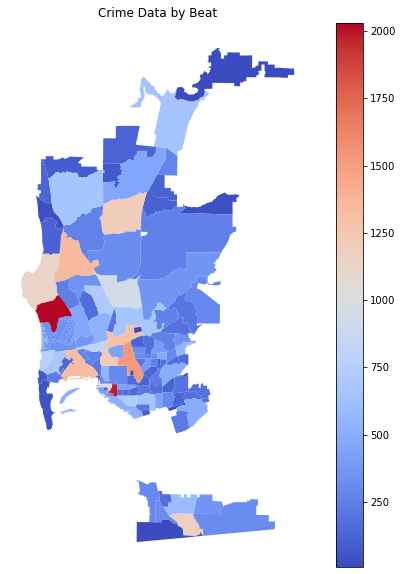

In [50]:
# visualize the data of crimes by beat
# Read the shapefile
shapefile_path = 'pd_beats_datasd/pd_beats_datasd.shp'
beat_geodata = gpd.read_file(shapefile_path)

# Convert beat column to numeric
beat_geodata['beat'] = pd.to_numeric(beat_geodata['beat'])

# copy model1_data to viz_data
viz_data = model1_data.copy()

# Merge the geodata with the aggregated stop data
merged_geodata = beat_geodata.merge(viz_data, on='beat')

# scale crimes between 0 and 1
#merged_geodata["num_crimes"] = merged_geodata["num_crimes"]/max(merged_geodata["num_crimes"])

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_geodata.plot(column='num_crimes', cmap='coolwarm', legend=True, ax=ax)
ax.set_title('Crime Data by Beat')
ax.set_axis_off()

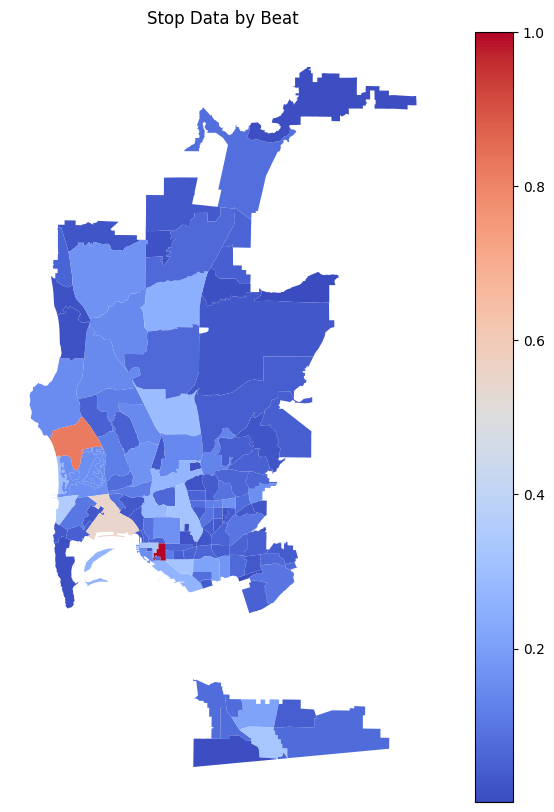

In [52]:
# scale stops between 0 and 1
merged_geodata["num_stops"] = merged_geodata["num_stops"]/max(merged_geodata["num_stops"])

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_geodata.plot(column='num_stops', cmap='coolwarm', legend=True, ax=ax)
ax.set_title('Stop Data by Beat')
ax.set_axis_off()

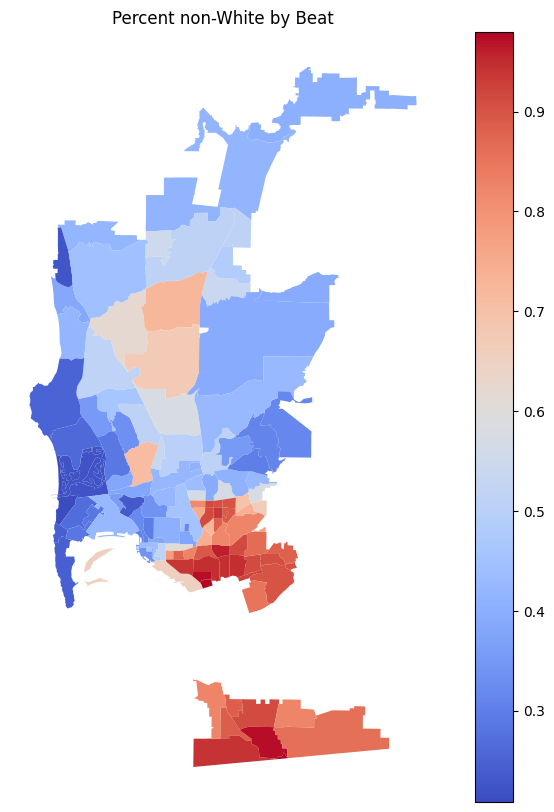

In [53]:
# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_geodata.plot(column='pct_non_white', cmap='coolwarm', legend=True, ax=ax)
ax.set_title('Percent non-White by Beat')
ax.set_axis_off()

## TODO: EDA
Descriptive Statistics:
- Calculate summary statistics (mean, median, mode, standard deviation) for the number of stops and crimes by beat.
- Analyze the distribution of stops and crimes by race and beat.
- Investigate the temporal trends of stops and crimes (daily, weekly, monthly, or yearly).

Visualizations
- Create bar plots or pie charts to show the distribution of stops and crimes by race.
- Generate line plots or bar plots to visualize the trends of stops and crimes over time (by beat or overall).
- Use heatmaps to display the correlation between stops and crimes by beat or by race.
- Plot a time series of stops and crimes to identify any patterns or seasonality.
- Create box plots or violin plots to visualize the distribution of stops and crimes by beat or race.

### Data Profiling

In [ ]:
# use pandas profiling to generate a report of the stops data
profile = ProfileReport(stops_data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# save the report to html
profile.to_file("stops_data_report.html")

In [ ]:
# use pandas profiling to generate a report of the crime data
profile = ProfileReport(crime_data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# save the report to html
profile.to_file("crime_data_report.html")

### Segregation Analysis

In [21]:
import libpysal
import segregation
import geopandas as gpd
import matplotlib.pyplot as plt

from segregation.local import MultiLocationQuotient, MultiLocalDiversity, MultiLocalEntropy, MultiLocalSimpsonInteraction, MultiLocalSimpsonConcentration, LocalRelativeCentralization


In [52]:
groups_list = ['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']


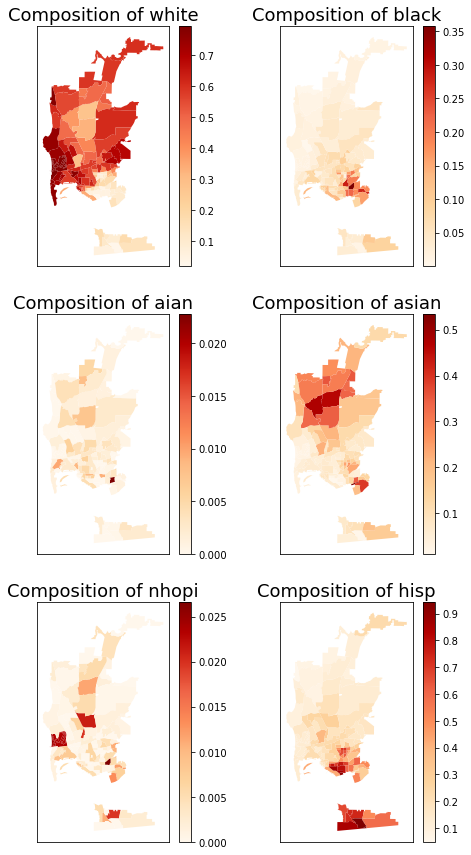

In [51]:
input_df = merged_geodata.copy()
for i in range(len(groups_list)):
    input_df['comp_' + groups_list[i]] = input_df[groups_list[i]] / input_df['total']

fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (8, 15))


input_df.plot(column = 'comp_' + groups_list[0],
              cmap = 'OrRd',
              legend = True, ax = axes[0,0])
axes[0,0].set_title('Composition of ' + groups_list[0], fontsize = 18)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,0].set_facecolor('white')


input_df.plot(column = 'comp_' + groups_list[1],
              cmap = 'OrRd',
              legend = True, ax = axes[0,1])
axes[0,1].set_title('Composition of ' + groups_list[1], fontsize = 18)
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[0,1].set_facecolor('white')


input_df.plot(column = 'comp_' + groups_list[2],
              cmap = 'OrRd',
              legend = True, ax = axes[1,0])
axes[1,0].set_title('Composition of ' + groups_list[2], fontsize = 18)
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
axes[1,0].set_facecolor('white')

input_df.plot(column = 'comp_' + groups_list[3],
              cmap = 'OrRd',
              legend = True, ax = axes[1,1])
axes[1,1].set_title('Composition of ' + groups_list[3], fontsize = 18)
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,1].set_facecolor('white')

input_df.plot(column = 'comp_' + groups_list[4],
              cmap = 'OrRd',
              legend = True, ax = axes[2,0])
axes[2,0].set_title('Composition of ' + groups_list[4], fontsize = 18)
axes[2,0].set_xticks([])
axes[2,0].set_yticks([])
axes[2,0].set_facecolor('white')

input_df.plot(column = 'comp_' + groups_list[5],
              cmap = 'OrRd',
              legend = True, ax = axes[2,1])
axes[2,1].set_title('Composition of ' + groups_list[5], fontsize = 18)
axes[2,1].set_xticks([])
axes[2,1].set_yticks([])
axes[2,1].set_facecolor('white')

Location Quotient (LQ)

In [54]:
index = MultiLocationQuotient(input_df, groups_list)
index.statistics

array([[1.40955323e+00, 4.26537301e-02, 3.05707229e-01, 1.80336996e+00,
        4.34592248e-01, 2.29701354e-01, 1.38872183e+00],
       [8.36875332e-01, 2.18149351e+00, 2.07201353e+00, 3.97274169e-01,
        1.34824650e+00, 1.31630300e+00, 5.91779875e-01],
       [8.36875332e-01, 2.18149351e+00, 2.07201353e+00, 3.97274169e-01,
        1.34824650e+00, 1.31630300e+00, 5.91779875e-01],
       [2.73094740e-01, 4.10171979e-01, 0.00000000e+00, 5.57406625e-01,
        2.84310352e+00, 2.26591103e+00, 8.06819200e-01],
       [1.12497100e+00, 1.05597629e+00, 8.42535803e-01, 4.83571494e-01,
        5.13319600e+00, 9.46134270e-01, 1.77310903e+00],
       [6.07020459e-01, 8.53498244e-01, 0.00000000e+00, 5.42529662e-01,
        0.00000000e+00, 1.80705382e+00, 7.12456616e-01],
       [1.72847832e+00, 4.00523188e-01, 1.20412093e+00, 3.95340326e-01,
        7.70298205e-01, 4.31613811e-01, 1.44387734e+00],
       [1.54814628e+00, 1.47433315e+00, 0.00000000e+00, 3.20344208e-01,
        0.00000000e+00, 5

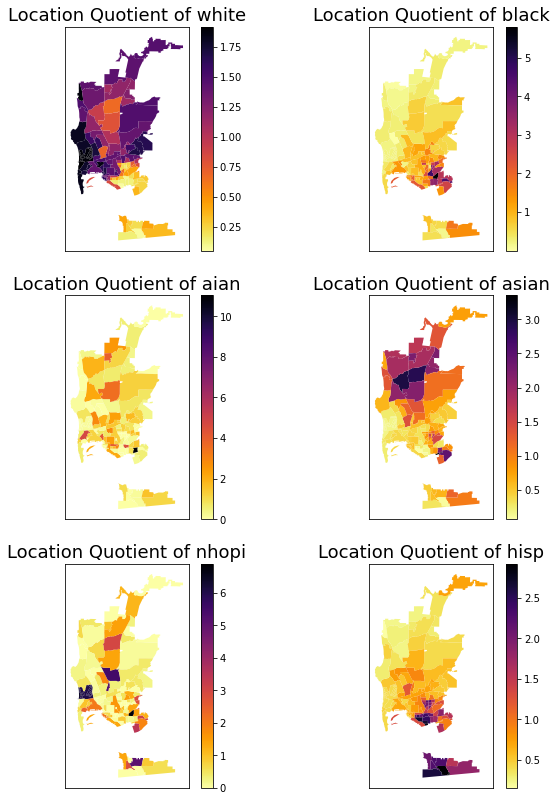

In [55]:
for i in range(len(groups_list)):
    input_df['LQ_' + groups_list[i]] = index.statistics[:,i]

fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (10, 14))


input_df.plot(column = 'LQ_' + groups_list[0],
              cmap = 'inferno_r',
              legend = True, ax = axes[0,0])
axes[0,0].set_title('Location Quotient of ' + groups_list[0], fontsize = 18)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,0].set_facecolor('white')


input_df.plot(column = 'LQ_' + groups_list[1],
              cmap = 'inferno_r',
              legend = True, ax = axes[0,1])
axes[0,1].set_title('Location Quotient of ' + groups_list[1], fontsize = 18)
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[0,1].set_facecolor('white')


input_df.plot(column = 'LQ_' + groups_list[2],
              cmap = 'inferno_r',
              legend = True, ax = axes[1,0])
axes[1,0].set_title('Location Quotient of ' + groups_list[2], fontsize = 18)
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
axes[1,0].set_facecolor('white')

input_df.plot(column = 'LQ_' + groups_list[3],
              cmap = 'inferno_r',
              legend = True, ax = axes[1,1])
axes[1,1].set_title('Location Quotient of ' + groups_list[3], fontsize = 18)
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,1].set_facecolor('white')

input_df.plot(column = 'LQ_' + groups_list[4],
              cmap = 'inferno_r',
              legend = True, ax = axes[2,0])
axes[2,0].set_title('Location Quotient of ' + groups_list[4], fontsize = 18)
axes[2,0].set_xticks([])
axes[2,0].set_yticks([])
axes[2,0].set_facecolor('white')

input_df.plot(column = 'LQ_' + groups_list[5],
              cmap = 'inferno_r',
              legend = True, ax = axes[2,1])
axes[2,1].set_title('Location Quotient of ' + groups_list[5], fontsize = 18)
axes[2,1].set_xticks([])
axes[2,1].set_yticks([])
axes[2,1].set_facecolor('white')

In [56]:
len(above_average_beats)

58

In [57]:
threshold = input_df['LQ_black'].quantile(0.75)
lq_black_list = input_df[input_df['LQ_black'] > threshold]['beat'].values

# Count the common elements between lq_black_list and above_average_beats
common_elements_count = sum(beat in above_average_beats for beat in lq_black_list)

# Calculate the percentage
percentage_black = (common_elements_count / len(lq_black_list)) * 100

print(f"Percentage of lq_black_list present in above_average_beats: {percentage_black:.2f}%")

Percentage of lq_black_list present in above_average_beats: 55.88%


In [58]:
threshold = input_df['LQ_white'].quantile(0.75)
lq_white_list = input_df[input_df['LQ_white'] > threshold]['beat'].values

# Count the common elements between lq_black_list and above_average_beats
common_elements_count = sum(beat in above_average_beats for beat in lq_white_list)

# Calculate the percentage
percentage_white = (common_elements_count / len(lq_white_list)) * 100

print(f"Percentage of lq_white_list present in above_average_beats: {percentage_white:.2f}%")


Percentage of lq_white_list present in above_average_beats: 44.12%


In [59]:
threshold = input_df['LQ_aian'].quantile(0.75)
lq_aian_list = input_df[input_df['LQ_aian'] > threshold]['beat'].values

# Count the common elements between lq_asian_list and above_average_beats
common_elements_count = sum(beat in above_average_beats for beat in lq_aian_list)

# Calculate the percentage
percentage_aian = (common_elements_count / len(lq_aian_list)) * 100

print(f"Percentage of lq_aian_list present in above_average_beats: {percentage_aian:.2f}%")


Percentage of lq_aian_list present in above_average_beats: 47.06%


In [60]:
threshold = input_df['LQ_asian'].quantile(0.75)
lq_asian_list = input_df[input_df['LQ_asian'] > threshold]['beat'].values

# Count the common elements between lq_black_list and above_average_beats
common_elements_count = sum(beat in above_average_beats for beat in lq_asian_list)

# Calculate the percentage
percentage_asian = (common_elements_count / len(lq_asian_list)) * 100

print(f"Percentage of lq_asian_list present in above_average_beats: {percentage_asian:.2f}%")


Percentage of lq_asian_list present in above_average_beats: 44.12%


In [61]:
threshold = input_df['LQ_hisp'].quantile(0.75)
lq_hisp_list = input_df[input_df['LQ_hisp'] > threshold]['beat'].values

# Count the common elements between lq_hisp_list and above_average_beats
common_elements_count = sum(beat in above_average_beats for beat in lq_hisp_list)

# Calculate the percentage
percentage_hisp = (common_elements_count / len(lq_hisp_list)) * 100

print(f"Percentage of lq_hisp_list present in above_average_beats: {percentage_hisp:.2f}%")

Percentage of lq_hisp_list present in above_average_beats: 73.53%


In [62]:
threshold = input_df['LQ_nhopi'].quantile(0.75)
lq_nhopi_list = input_df[input_df['LQ_nhopi'] > threshold]['beat'].values

# Count the common elements between lq_nhopi_list and above_average_beats
common_elements_count = sum(beat in above_average_beats for beat in lq_nhopi_list)

# Calculate the percentage
percentage_nhopi = (common_elements_count / len(lq_nhopi_list)) * 100

print(f"Percentage of lq_nhopi_list present in above_average_beats: {percentage_nhopi:.2f}%")

Percentage of lq_nhopi_list present in above_average_beats: 47.06%


In [64]:
print(groups_list)

['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']


Text(0.5, 1.0, 'Percentage of Beats with Above Average Stops in Areas that are within the Location Quotient 75th Quantile')

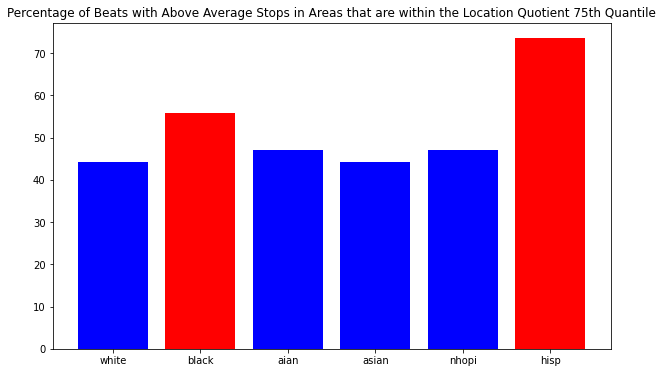

In [65]:
# create a bar plot of all the percentages
plt.figure(figsize = (10, 6))

# change color of values above 50
plt.bar(x = groups_list[:-1], height = [percentage_white, percentage_black, percentage_aian, percentage_asian,percentage_nhopi, percentage_hisp], color = ['red' if x > 50 else 'blue' for x in [percentage_white, percentage_black, percentage_aian, percentage_asian,percentage_nhopi, percentage_hisp]])

plt.title('Percentage of Beats with Above Average Stops in Areas that are within the Location Quotient 75th Quantile', fontsize = 12)

In [66]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Fit a linear regression model
X = model1_data[['num_crimes']]
y = model1_data['num_stops']
reg = LinearRegression().fit(X, y)

# Calculate the percentage difference between num_stops and predicted_stops for each beat
percentage_diff = []
for index, row in model1_data.iterrows():
    predicted_stops = reg.predict([[row['num_crimes']]])
    diff = (row['num_stops'] - predicted_stops) / predicted_stops * 100
    percentage_diff.append((row['beat'], diff[0]))

# Store the percentage differences in a new DataFrame
percentage_diff_df = pd.DataFrame(percentage_diff, columns=['beat', 'percentage_diff'])

# Sort the DataFrame by the percentage difference in descending order
sorted_percentage_diff_df = percentage_diff_df.sort_values(by='percentage_diff', ascending=False)

# Display the sorted DataFrame
print(sorted_percentage_diff_df)

      beat  percentage_diff
88   714.0       499.796255
76   618.0       280.308193
54   514.0       193.882047
105  828.0       159.914771
119  933.0       121.643817
..     ...              ...
85   711.0      -154.302866
38   435.0      -176.939603
26   316.0      -228.350132
118  932.0      -354.591168
75   617.0     -1050.664175

[124 rows x 2 columns]


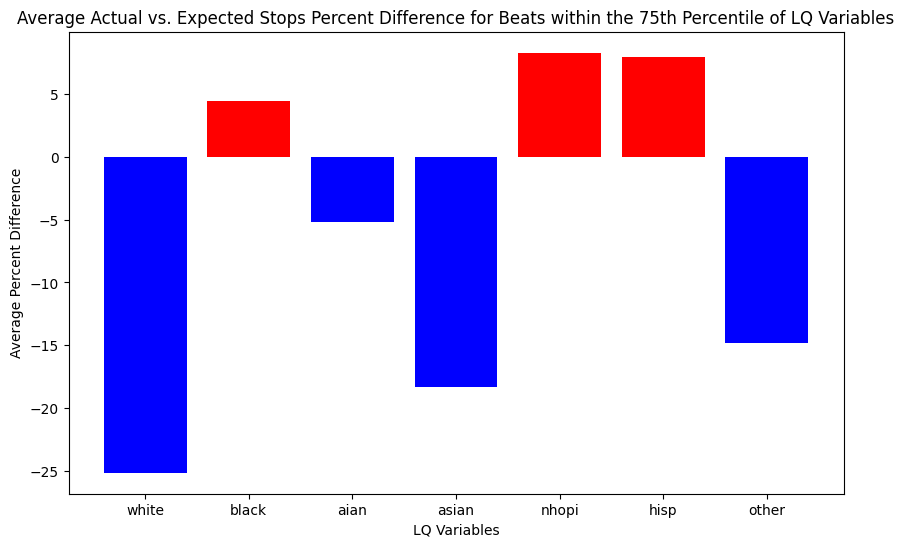

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lq_variables = ['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']
avg_percent_diff_list = []

# Calculate the average percent difference for each LQ variable
for var in lq_variables:
    # Find the 75th percentile value for the LQ variable
    threshold = input_df[f"LQ_{var}"].quantile(0.75)
    
    # Filter input_df to keep only the rows above the 75th percentile value
    filtered_input_df = input_df[input_df[f"LQ_{var}"] > threshold]
    
    # Merge the filtered DataFrame with sorted_percentage_diff_df to get the percentage differences
    merged_df = filtered_input_df.merge(sorted_percentage_diff_df, on='beat')
    
    # Calculate the average percent difference for the LQ variable
    avg_percent_diff = merged_df['percentage_diff'].mean()
    avg_percent_diff_list.append(avg_percent_diff)

plt.figure(figsize=(10, 6))

# Create a bar plot for the average percent differences
plt.bar(lq_variables, avg_percent_diff_list, color=['red' if x > 0 else 'blue' for x in avg_percent_diff_list])
plt.xlabel("LQ Variables")
plt.ylabel("Average Percent Difference")
plt.title("Average Actual vs. Expected Stops Percent Difference for Beats within the 75th Percentile of LQ Variables")
plt.show()


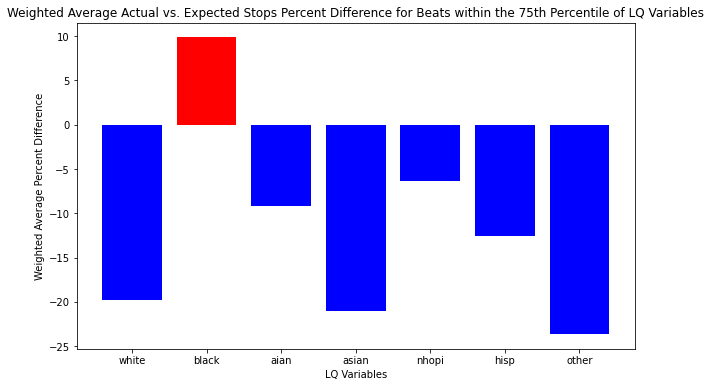

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lq_variables = ['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']
weighted_avg_percent_diff_list = []

# Calculate the weighted average percent difference for each LQ variable
for var in lq_variables:
    # Find the 75th percentile value for the LQ variable
    threshold = input_df[f"LQ_{var}"].quantile(0.75)
    
    # Filter input_df to keep only the rows above the 75th percentile value
    filtered_input_df = input_df[input_df[f"LQ_{var}"] > threshold]
    
    # Merge the filtered DataFrame with sorted_percentage_diff_df to get the percentage differences
    merged_df = filtered_input_df.merge(sorted_percentage_diff_df, on='beat')
    
    # Calculate the weighted average percent difference for the LQ variable using the "total" column as weights
    weighted_avg_percent_diff = np.average(merged_df['percentage_diff'], weights=merged_df['total'])
    weighted_avg_percent_diff_list.append(weighted_avg_percent_diff)

plt.figure(figsize=(10, 6))


# Create a bar plot for the weighted average percent differences
plt.bar(lq_variables, weighted_avg_percent_diff_list, color=['red' if x > 0 else 'blue' for x in weighted_avg_percent_diff_list])
plt.xlabel("LQ Variables")
plt.ylabel("Weighted Average Percent Difference")
plt.title("Weighted Average Actual vs. Expected Stops Percent Difference for Beats within the 75th Percentile of LQ Variables")
plt.show()

In [68]:
model1_linear= smf.ols(formula=' num_stops ~ num_crimes', data=input_df).fit()
model1_linear_race= smf.ols(formula=' num_stops ~ num_crimes + pct_non_white', data=input_df).fit()
model1_lq= smf.ols(formula=' num_stops ~ num_crimes + LQ_black+ LQ_white + LQ_aian + LQ_asian + LQ_nhopi + LQ_hisp+ LQ_other', data=input_df).fit()
print(model1_lq.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     63.65
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           1.65e-38
Time:                        00:26:25   Log-Likelihood:                -1063.3
No. Observations:                 135   AIC:                             2143.
Df Residuals:                     127   BIC:                             2166.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7204     41.163      0.188      0.8

In [69]:
# use stargazer to compare the results of the linear regression and poisson regression models

stargazer = Stargazer([model1_linear, model1_linear_race, model1_lq])
#stargazer.covariate_order(['Intercept', 'num_stops'])
stargazer.rename_covariates({'Intercept': 'Constant', 'num_crimes': 'Crimes', 'pct_non_white': 'Pct. Non-White'})
stargazer.custom_columns(["Linear", "Linear with Race", "Location Quotient"], [1, 1 ,1])
stargazer.title('Basic Regression Models')

presentation_output = stargazer.render_html()


with open("regression table 1.html", "w") as file:
    file.write(presentation_output)

Multigroup Local Diversity Index (higher is more diverse)

In [71]:
index = MultiLocalDiversity(input_df, groups_list)
index.statistics[0:10]

array([1.05099907, 1.31020718, 1.31020718, 0.93747687, 1.3624826 ,
       1.12395952, 0.97083531, 1.07934183, 0.3560799 , 0.94751538])

Text(0.5, 1.0, 'Local Diversity')

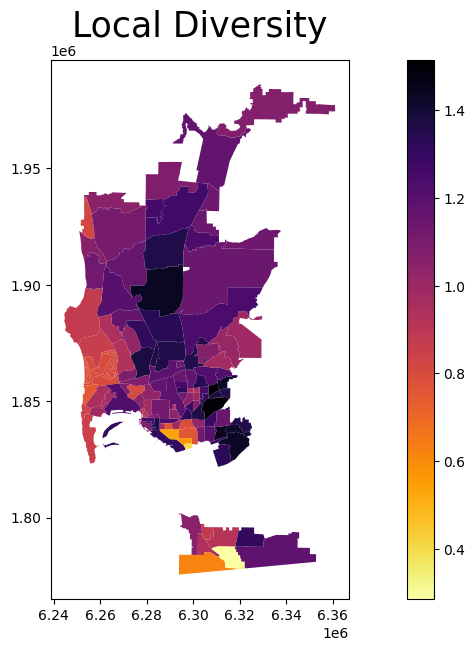

In [72]:
input_df['Local_Diversity'] = index.statistics
input_df.head()
ax = input_df.plot(column = 'Local_Diversity', cmap = 'inferno_r', legend = True, figsize = (15,7))
ax.set_title("Local Diversity", fontsize = 25)

Local Entropy Index (higher is more diverse)

In [73]:
index = MultiLocalEntropy(input_df, groups_list)
index.statistics[0:10] # Values of first 10 units

array([0.54010668, 0.6733133 , 0.6733133 , 0.48176781, 0.70017755,
       0.57760093, 0.49891066, 0.55467198, 0.18298887, 0.48692658])

Text(0.5, 1.0, 'Local Entropy')

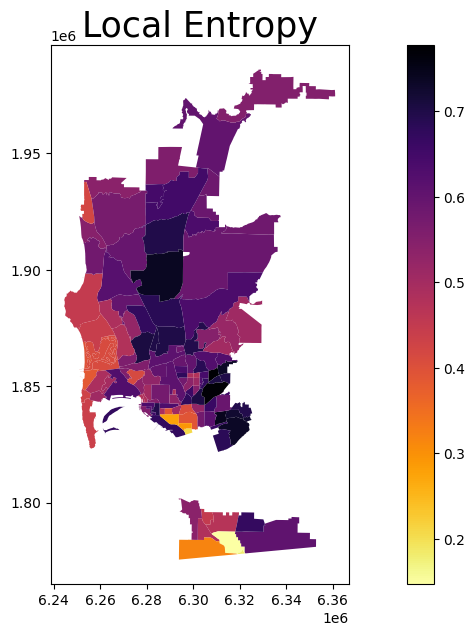

In [74]:
input_df['Local_Entropy'] = index.statistics
input_df.head()
ax = input_df.plot(column = 'Local_Entropy', cmap = 'inferno_r', legend = True, figsize = (15,7))
ax.set_title("Local Entropy", fontsize = 25)

Local Centralization (single group)

In [75]:
index = LocalRelativeCentralization(input_df, 'black', 'total')
index.statistics[0:10] # Values of first 10 units

array([-0.16098961,  0.26539355,  0.21144274, -0.0122849 ,  0.02410638,
        0.05360423, -0.05280929, -0.1853753 , -0.21178278, -0.03786545])

Text(0.5, 1.0, 'Local Centralization - Black')

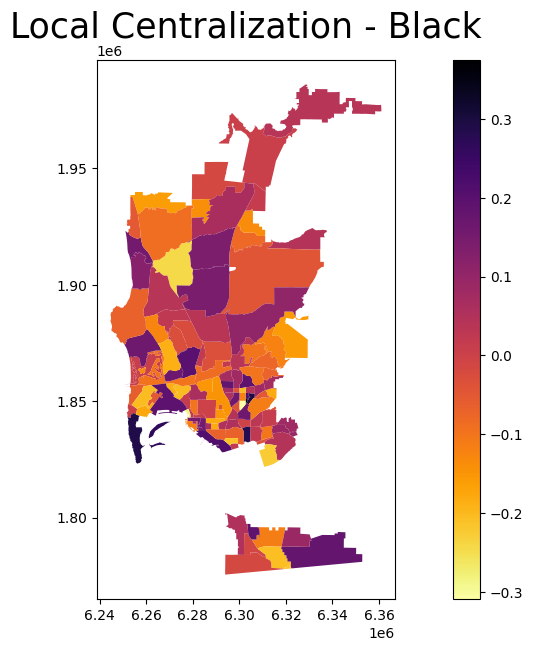

In [76]:
input_df['Local_Centralization_black'] = index.statistics
input_df.head()
ax = input_df.plot(column = 'Local_Centralization_black', cmap = 'inferno_r', legend = True, figsize = (15,7))
ax.set_title("Local Centralization - Black", fontsize = 25)

Text(0.5, 1.0, 'Local Centralization - White')

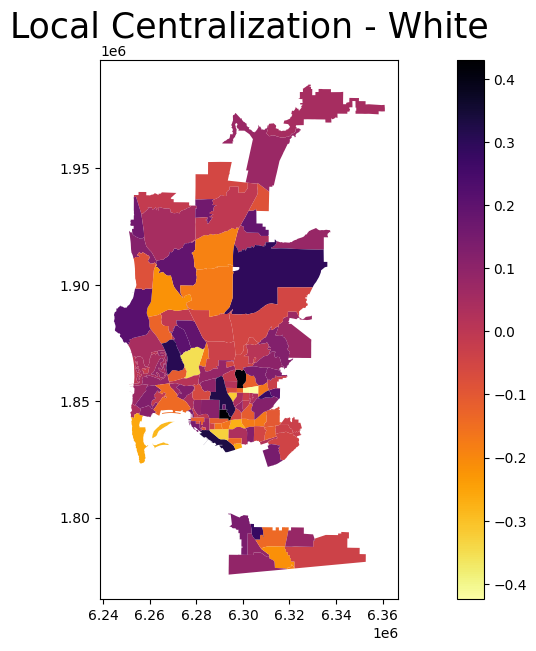

In [77]:
# Local Centralization - White
index = LocalRelativeCentralization(input_df, 'white', 'total')
index.statistics[0:10] # Values of first 10 units

input_df['Local_Centralization_white'] = index.statistics
input_df.head()
ax = input_df.plot(column = 'Local_Centralization_white', cmap = 'inferno_r', legend = True, figsize = (15,7))
ax.set_title("Local Centralization - White", fontsize = 25)

In [78]:
# local diversity regression
model1_linear_diversity = smf.ols(formula=' num_stops ~ num_crimes + Local_Diversity', data=input_df).fit()
print(model1_linear_diversity.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     208.0
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           1.56e-41
Time:                        17:46:17   Log-Likelihood:                 174.41
No. Observations:                 135   AIC:                            -342.8
Df Residuals:                     132   BIC:                            -334.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0326      0.026     

## Additional Visualizations

In [79]:
print("Summary statistics for crime_stops_demographics_by_beat:")
print(crime_stops_demographics_by_beat.describe())

Summary statistics for crime_stops_demographics_by_beat:
             beat   num_crimes     num_stops         total         white  \
count  124.000000   124.000000    124.000000    124.000000    124.000000   
mean   536.161290  1154.161290   3210.338710  11164.669355   4749.024194   
std    239.596218  1138.528143   4173.597253  11715.007300   6268.768058   
min    111.000000    26.000000     30.000000    194.000000      4.000000   
25%    324.750000   446.250000   1055.250000   4379.500000    745.250000   
50%    523.500000   822.500000   1827.500000   7577.500000   2399.000000   
75%    724.250000  1399.000000   3884.500000  12537.250000   5796.250000   
max    937.000000  6087.000000  29982.000000  69871.000000  30470.000000   

             black        aian         asian       nhopi          hisp  \
count   124.000000  124.000000    124.000000  124.000000    124.000000   
mean    680.991935   23.846774   1843.790323   42.467742   3394.903226   
std     785.646546   40.177259   387

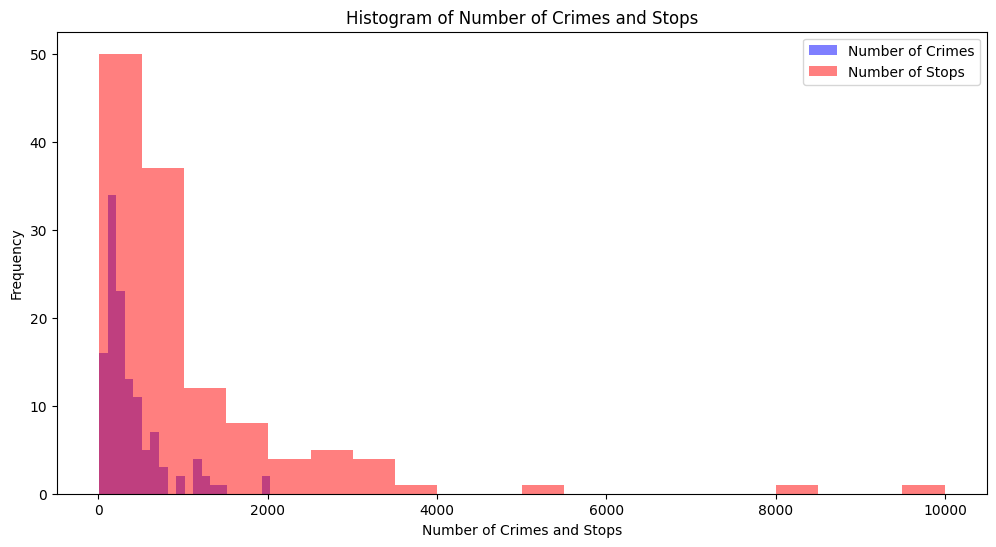

In [80]:
plt.figure(figsize=(12, 6))
plt.hist(model1_data['num_crimes'], bins=20, alpha=0.5, color='blue', label='Number of Crimes')
plt.hist(model1_data['num_stops'], bins=20, alpha=0.5, color='red', label='Number of Stops')
plt.legend(loc='upper right')
plt.xlabel('Number of Crimes and Stops')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Crimes and Stops')
plt.show()

In [81]:
correlation_matrix = model1_data.corr()

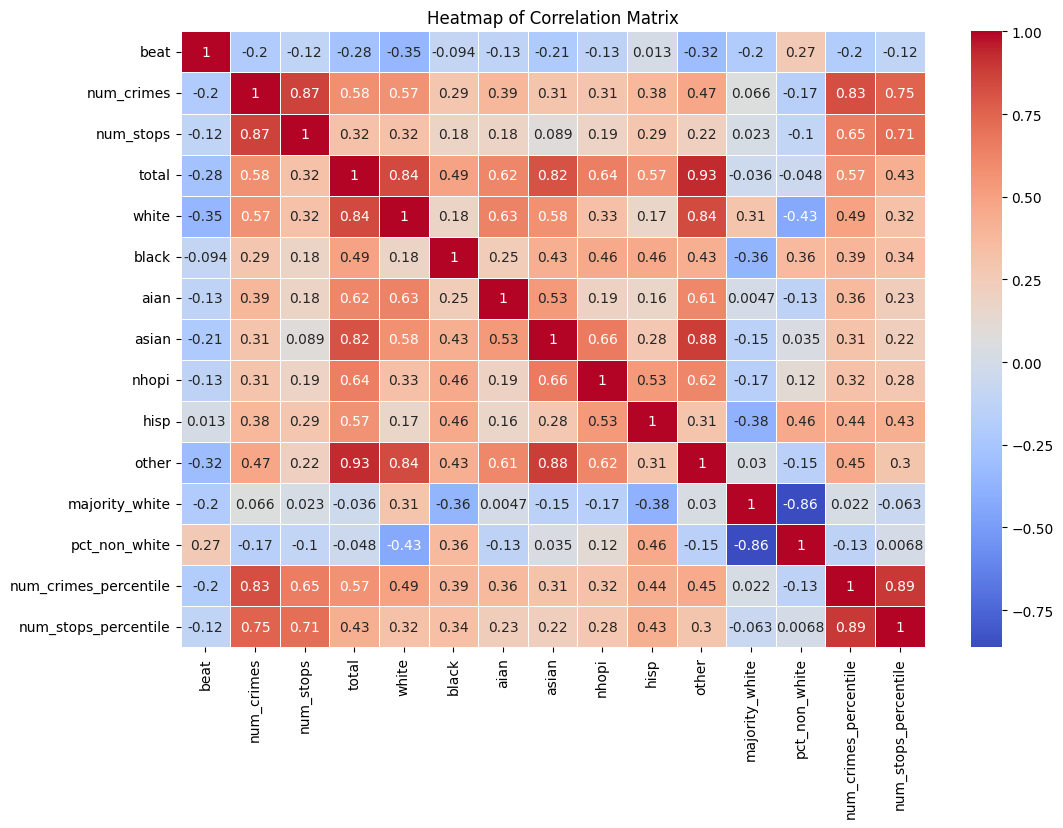

In [82]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


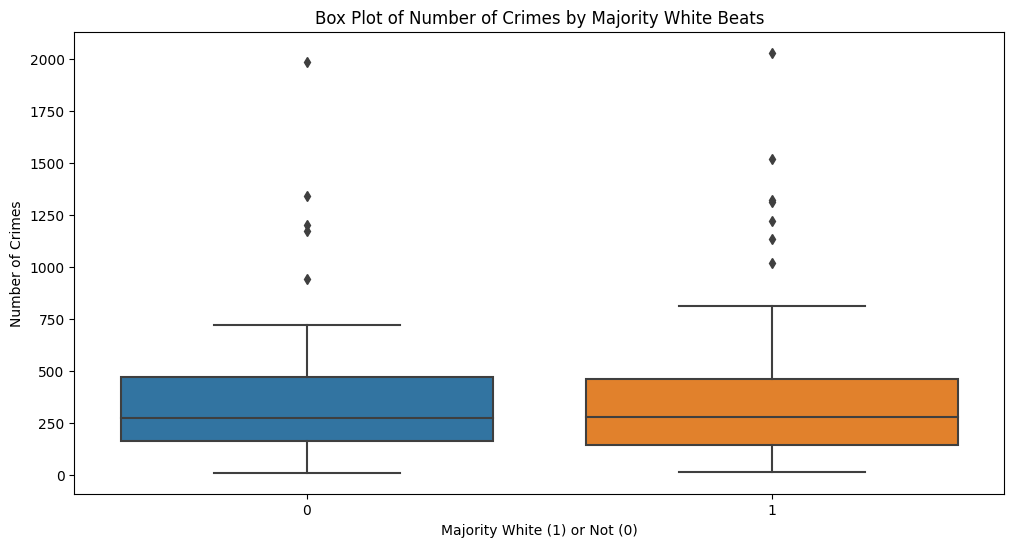

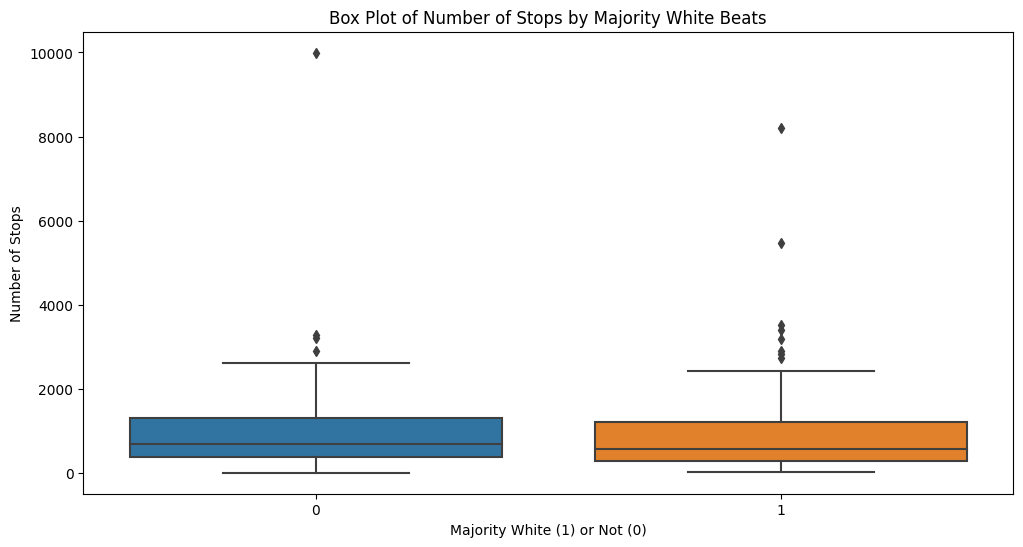

In [83]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='majority_white', y='num_crimes', data=model1_data)
plt.xlabel('Majority White (1) or Not (0)')
plt.ylabel('Number of Crimes')
plt.title('Box Plot of Number of Crimes by Majority White Beats')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='majority_white', y='num_stops', data=model1_data)
plt.xlabel('Majority White (1) or Not (0)')
plt.ylabel('Number of Stops')
plt.title('Box Plot of Number of Stops by Majority White Beats')
plt.show()

<AxesSubplot: title={'center': 'Number of Stops by Race'}>

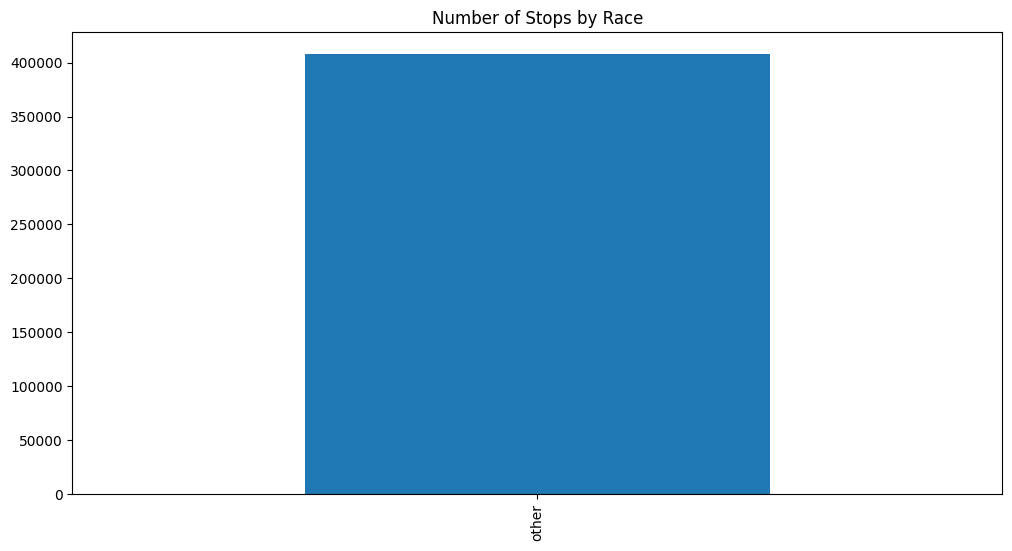

In [84]:
stops_by_race = stops_data['race'].value_counts().sort_index()

stops_by_race.plot(kind='bar', figsize=(12, 6), title="Number of Stops by Race")

Text(0, 0.5, 'Count')

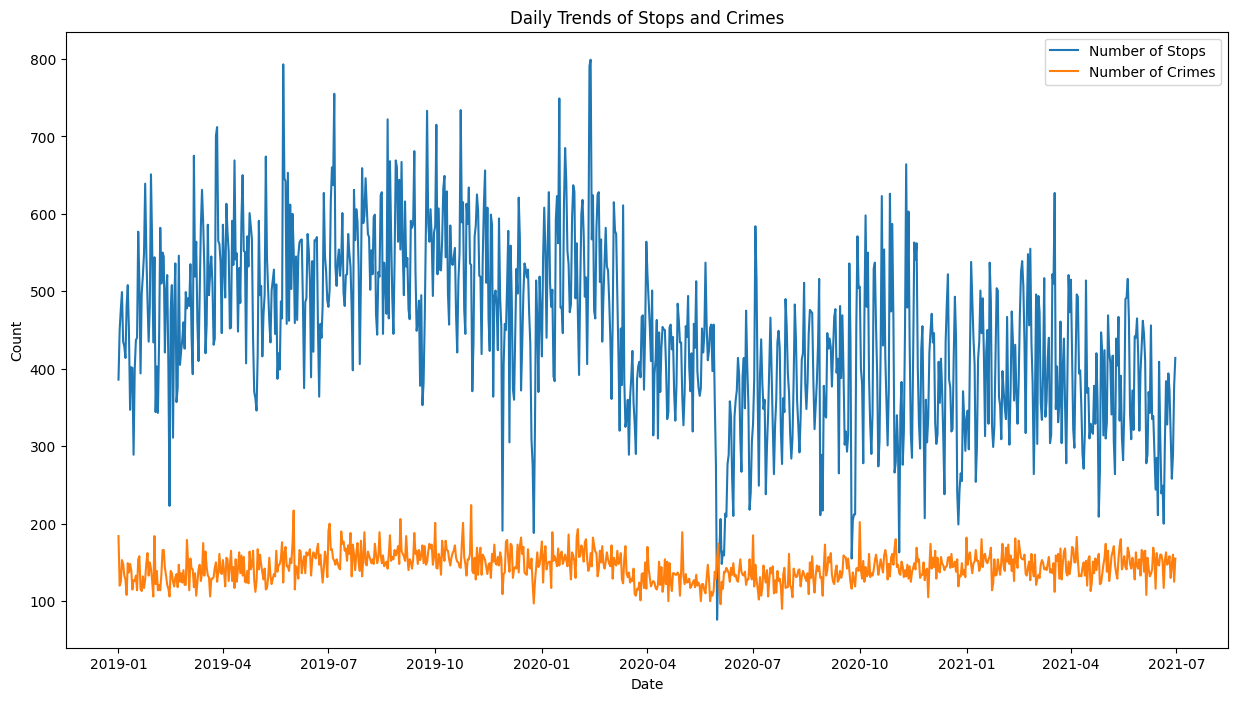

In [85]:
# Convert 'date' column to datetime format
stops_data['date'] = pd.to_datetime(stops_data['date'])

# Aggregate stops and crimes by day
stops_by_day = stops_data.groupby(stops_data['date'].dt.date).size().reset_index(name='num_stops')
crime_by_day = crime_data.groupby(crime_data['activityDate'].dt.date).size().reset_index(name='num_crimes')

# Find common minimum and maximum dates
min_date = max(stops_by_day['date'].min(), crime_by_day['activityDate'].min())
max_date = min(stops_by_day['date'].max(), crime_by_day['activityDate'].max())

# Filter datasets to include only the common date range
stops_by_day_filtered = stops_by_day[(stops_by_day['date'] >= min_date) & (stops_by_day['date'] <= max_date)]
crime_by_day_filtered = crime_by_day[(crime_by_day['activityDate'] >= min_date) & (crime_by_day['activityDate'] <= max_date)]

# Merge filtered stops and crimes by day
daily_trends_filtered = pd.merge(stops_by_day_filtered, crime_by_day_filtered, left_on='date', right_on='activityDate', how='outer').fillna(0)

# Rename columns
daily_trends_filtered.rename(columns={'date': 'Date', 'num_stops': 'Number of Stops', 'num_crimes': 'Number of Crimes'}, inplace=True)

# Set Date as index
daily_trends_filtered.set_index('Date', inplace=True)

# Plot filtered daily trends of stops and crimes
ax = daily_trends_filtered.plot(figsize=(15, 8), title='Daily Trends of Stops and Crimes')
ax.set_xlabel('Date')
ax.set_ylabel('Count')



Text(0, 0.5, 'Seasonal Component')

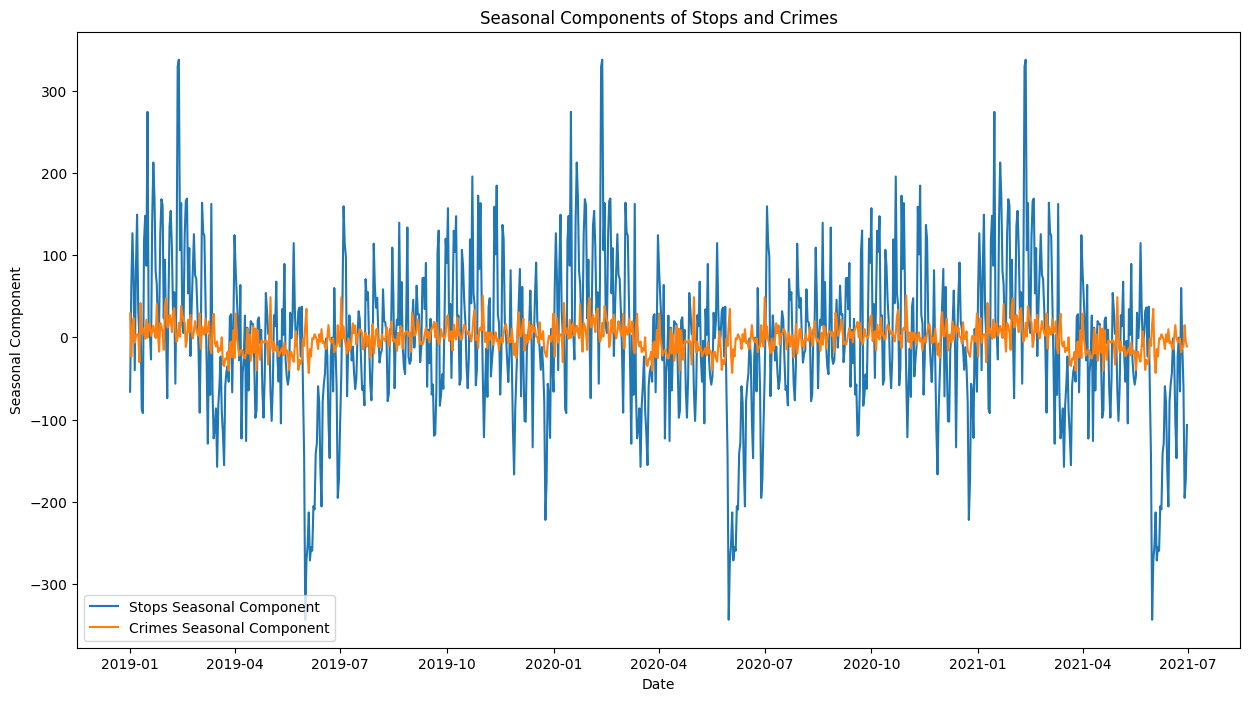

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition for stops and crimes
stops_decomposition = seasonal_decompose(daily_trends_filtered['Number of Stops'], model='additive', period=365)
crimes_decomposition = seasonal_decompose(daily_trends_filtered['Number of Crimes'], model='additive', period=365)

# Create a DataFrame with seasonal components
seasonal_components = pd.DataFrame({
    'Stops Seasonal Component': stops_decomposition.seasonal,
    'Crimes Seasonal Component': crimes_decomposition.seasonal
})

# Plot seasonal components
ax = seasonal_components.plot(figsize=(15, 8), title='Seasonal Components of Stops and Crimes')
ax.set_xlabel('Date')
ax.set_ylabel('Seasonal Component')

### Regressions on subset of beats depending on concentrations of different racial groups

### Fixed Effects Regression by Beat [Jordan]

In [87]:
# First, modify the stops_by_day and crime_by_day DataFrames to include the 'beat' variable
stops_by_day = stops_data.groupby(['date', 'beat']).size().reset_index(name='num_stops')
crime_by_day = crime_data.groupby(['activityDate', 'beat']).size().reset_index(name='num_crimes')

# Merge the stops and crime data by date and beat
merged_data = pd.merge(stops_by_day, crime_by_day, left_on=['date', 'beat'], right_on=['activityDate', 'beat'], how='outer')

# Fill missing values with 0 and convert the 'date' column to datetime
merged_data['num_stops'].fillna(0, inplace=True)
merged_data['num_crimes'].fillna(0, inplace=True)
merged_data['date'].fillna(merged_data['activityDate'], inplace=True)
merged_data.drop('activityDate', axis=1, inplace=True)

# Pivot the merged data to create a panel dataset with a MultiIndex (beat, date)
panel_data = merged_data.pivot_table(index=['beat', 'date'], values=['num_stops', 'num_crimes'], aggfunc='sum')

# Run a fixed-effects regression using PanelOLS
from linearmodels import PanelOLS
model = PanelOLS(panel_data['num_stops'], panel_data['num_crimes'], entity_effects=True)
fixed_effects_result = model.fit()

print(fixed_effects_result)

                          PanelOLS Estimation Summary                           
Dep. Variable:              num_stops   R-squared:                        0.2725
Estimator:                   PanelOLS   R-squared (Between):             -9.2201
No. Observations:              220424   R-squared (Within):               0.2725
Date:                Fri, Apr 28 2023   R-squared (Overall):             -0.6803
Time:                        17:46:25   Log-likelihood                -6.273e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                    8.25e+04
Entities:                         172   P-value                           0.0000
Avg Obs:                       1281.5   Distribution:                F(1,220251)
Min Obs:                       1.0000                                           
Max Obs:                       6749.0   F-statistic (robust):           8.25e+04
                            

In [88]:
model1_data.head()

,beat,num_crimes,num_stops,total,white,black,aian,asian,nhopi,hisp,other,majority_white,pct_non_white,num_crimes_percentile,num_stops_percentile
0,111.0,705.000000,1489.000000,27069,13222,1530,0,5210,191,6035,881,0,0.511545,0.879032,0.790323
1,112.0,159.333333,514.000000,12344,8237,282,2,1245,22,2098,458,1,0.332712,0.282258,0.411290
2,113.0,249.000000,504.666667,12721,8210,1,0,784,0,3108,618,1,0.354610,0.451613,0.395161
3,114.0,350.666667,1178.000000,16373,8843,339,3,2183,0,4318,687,1,0.459903,0.653226,0.725806
4,115.0,1339.000000,1487.666667,49954,24314,871,220,16481,27,5845,2196,0,0.513272,0.975806,0.782258


In [89]:
# Aggregate stops and crimes by beat and date
stops_by_beat_date = stops_data.groupby(['beat', stops_data['date'].dt.date]).size().reset_index(name='num_stops')
crime_by_beat_date = crime_data.groupby(['beat', crime_data['activityDate'].dt.date]).size().reset_index(name='num_crimes')

# Merge the stops and crime data by beat and date
merged_data = pd.merge(stops_by_beat_date, crime_by_beat_date, left_on=['beat', 'date'], right_on=['beat', 'activityDate'], how='outer').fillna(0)
merged_data.drop(columns=['activityDate'], inplace=True)

# Convert beat values to integers and then to strings
merged_data['beat'] = merged_data['beat'].astype(int).astype(str)

# Create beat dummies and interaction terms
beat_dummies = pd.get_dummies(merged_data['beat'], prefix='beat', drop_first=True)
merged_data_dummies = pd.concat([merged_data, beat_dummies], axis=1)

interaction_terms = []
for col in beat_dummies.columns:
    interaction_term = f'num_crimes_{col}'
    merged_data_dummies[interaction_term] = merged_data_dummies['num_crimes'] * merged_data_dummies[col]
    interaction_terms.append(interaction_term)

# Fit the regression model
regression_formula = 'num_stops ~ num_crimes + ' + ' + '.join(beat_dummies.columns) + ' + ' + ' + '.join(interaction_terms)
regression_model = smf.ols(formula=regression_formula, data=merged_data_dummies).fit()
print(regression_model.summary())


                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     245.4
Date:                Fri, 28 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:46:34   Log-Likelihood:            -2.9341e+05
No. Observations:               96010   AIC:                         5.874e+05
Df Residuals:                   95709   BIC:                         5.903e+05
Df Model:                         300                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            6.662e+09   4

In [90]:
# Merge race data
merged_data_dummies['beat'] = merged_data_dummies['beat'].astype(int).astype(str)
beat_demographics['beat'] = beat_demographics['beat'].astype(int).astype(str)
merged_data_race = pd.merge(merged_data_dummies, beat_demographics, on='beat')

# Calculate the percentage of each race in each beat
race_columns = ['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']
for col in race_columns:
    merged_data_race[f'pct_{col}'] = merged_data_race[col] / merged_data_race['total']

# Update the regression formula to include race data
regression_formula = (
    'num_stops ~ num_crimes + '
    + ' + '.join(beat_dummies.columns)
    + ' + '
    + ' + '.join(interaction_terms)
    + ' + '
    + ' + '.join([f'pct_{col}' for col in race_columns])
)

# Fit the regression model with race data
regression_model_race = smf.ols(formula=regression_formula, data=merged_data_race).fit()
print(regression_model_race.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     294.6
Date:                Fri, 28 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:46:44   Log-Likelihood:            -2.8928e+05
No. Observations:               94934   AIC:                         5.791e+05
Df Residuals:                   94683   BIC:                         5.814e+05
Df Model:                         250                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3.279e+11   8

In [91]:
print(merged_data_race.isnull().sum())
print(merged_data_race.shape)

beat          0
date          0
num_stops     0
num_crimes    0
beat_100      0
             ..
pct_aian      0
pct_asian     0
pct_nhopi     0
pct_hisp      0
pct_other     0
Length: 361, dtype: int64
(94934, 361)


In [92]:
merged_data_race.head()

,beat,date,num_stops,num_crimes,beat_100,beat_11,beat_111,beat_112,beat_113,beat_114,...,nhopi,hisp,other,pct_white,pct_black,pct_aian,pct_asian,pct_nhopi,pct_hisp,pct_other
0,111,2019-01-01,2.0,2.0,0,0,1,0,0,0,...,191,6035,881,0.488455,0.056522,0.0,0.192471,0.007056,0.222949,0.032546
1,111,2019-01-02,13.0,2.0,0,0,1,0,0,0,...,191,6035,881,0.488455,0.056522,0.0,0.192471,0.007056,0.222949,0.032546
2,111,2019-01-03,10.0,1.0,0,0,1,0,0,0,...,191,6035,881,0.488455,0.056522,0.0,0.192471,0.007056,0.222949,0.032546
3,111,2019-01-04,2.0,4.0,0,0,1,0,0,0,...,191,6035,881,0.488455,0.056522,0.0,0.192471,0.007056,0.222949,0.032546
4,111,2019-01-05,4.0,7.0,0,0,1,0,0,0,...,191,6035,881,0.488455,0.056522,0.0,0.192471,0.007056,0.222949,0.032546


In [94]:
# Convert the 'date' columns to datetime
stops_by_day['date'] = pd.to_datetime(stops_by_day['date'])
crime_by_day['activityDate'] = pd.to_datetime(crime_by_day['activityDate'])
crime_by_day['beat'] = crime_by_day['beat'].astype(int).astype(str)
stops_by_day['beat'] = stops_by_day['beat'].astype(int).astype(str)

# Merge the stops_by_day and crime_by_day data on 'date' and 'beat'
merged_data = pd.merge(stops_by_day, crime_by_day, left_on=['date', 'beat'], right_on=['activityDate', 'beat'], how='outer').fillna(0)

# Fill missing 'date' and 'activityDate' values with a placeholder date (1900-01-01)
placeholder_date = pd.to_datetime('1900-01-01')
merged_data['date'].where(merged_data['date'] != 0, placeholder_date, inplace=True)
merged_data['activityDate'].where(merged_data['activityDate'] != 0, placeholder_date, inplace=True)

# Update 'date' and 'activityDate' columns with the correct dates and convert to datetime
merged_data['activityDate'] = merged_data['date'].where(merged_data['date'] != placeholder_date, merged_data['activityDate'])
merged_data['activityDate'] = pd.to_datetime(merged_data['activityDate'])

# Drop the 'date' column and set the index to 'activityDate'
merged_data.drop('date', axis=1, inplace=True)
merged_data.set_index('activityDate', inplace=True)

# Merge race data
merged_data['beat'] = merged_data['beat'].astype(str)  # Convert beat to string type
beat_demographics['beat'] = beat_demographics['beat'].astype(str)
merged_data_race = pd.merge(merged_data.reset_index(), beat_demographics, on='beat').set_index('activityDate')

# Calculate the percentage of each race in each beat
race_columns = ['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']
for col in race_columns:
    merged_data_race[f'pct_{col}'] = merged_data_race[col] / merged_data_race['total'] * 100

# Create dummy variables for the 'beat' column
beat_dummies = pd.get_dummies(merged_data_race['beat'], prefix='beat', drop_first=True)
merged_data_race = pd.concat([merged_data_race, beat_dummies], axis=1)

# Create the regression formula
dependent_variable = "num_crimes"
independent_variables = [f"pct_{col}" for col in race_columns] + ["num_stops"]
interaction_terms = [f"{b}*{var}" for b in beat_dummies.columns for var in independent_variables]

regression_formula = f"{dependent_variable} ~ {' + '.join(independent_variables)}"
if interaction_terms:
    regression_formula += f" + {' + '.join(interaction_terms)}"

# Run the regression
regression_model = smf.ols(formula=regression_formula, data=merged_data_race).fit()
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:             num_crimes   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     804.1
Date:                Fri, 28 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:48:33   Log-Likelihood:                -89628.
No. Observations:              218358   AIC:                         1.798e+05
Df Residuals:                  218108   BIC:                         1.823e+05
Df Model:                         249                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.794e+10   1.13

# Data Set Summary

The data used in this project spans multiple years (2019-2021) and is derived from various sources.

The primary datasets used in the analysis are the stop data files, which include information on stops conducted by SDPD for the years 2019, 2020, and 2021. These files provide comprehensive data on each stop, such as the location, demographics of the person stopped, reason for the stop, and other relevant details. The stop data is collected under the Racial and Identity Profiling Act of 2015 (RIPA), which requires nearly all California law enforcement agencies to submit demographic data on all detentions and searches. This data is publicly available and can be downloaded from the City of San Diego's data portal: https://data.sandiego.gov/datasets/police-ripa-stops/. By combining these files, a complete picture of police stops over the three years can be obtained.

To gain insights into the spatial distribution of police stops, **shapefiles for SDPD beats** are used. These files contain the geographic boundaries of police beats, which are essential for visualizing and understanding the spatial patterns of stops and crimes in San Diego.

Additionally, **population data** for each beat is incorporated into the analysis. This data is sourced from the U.S. Census Bureau's American Community Survey (ACS) for 2019, which provides demographic information, including the racial composition of residents within each beat. By including this data, potential racial biases in police stops can be identified and examined.

Finally, a dataset containing all crimes reported to the SDPD between 2019 and 2021 is utilized. This data was obtained under the California Public Records Act (PRA) by the San Diego Union-Tribune and is essential for understanding the relationship between police stops and crime incidents in San Diego. By merging this dataset with the stop data and beat demographics, a comprehensive analysis of the spatial and demographic aspects of police stops can be conducted.

**So far**, the project has focused on cleaning, preprocessing, and merging the datasets to facilitate the analysis. Additionally, some preliminary visualizations have been created to explore the spatial distribution of police stops and crime incidents across San Diego. Furthermore, several regression models have been suggested to investigate the relationship between police stops, crime incidents, and demographic variables, including both Poisson and linear regression models. These models will be used to provide a more in-depth understanding of the factors influencing police stops in San Diego and whether they align with the occurrence of crime incidents.

### References
Papers
- https://www.ojp.gov/ncjrs/virtual-library/abstracts/impact-stops-and-searches-crime-and-community
- https://onlinelibrary.wiley.com/doi/10.1111/1745-9133.12172
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0157223
- https://onlinelibrary.wiley.com/doi/10.1002/cl2.1302

Articles
- Moran, G., Winkley, L., &amp; SCHROEDER, L. A. U. R. Y. N. (2022, January 16). Stopped by police in San Diego? A lot depends on where you live, Drive. The Sand Diego Union-Tribune. Retrieved April 2, 2023, from https://www.sandiegouniontribune.com/news/watchdog/story/2022-01-16/stopped-by-police-in-san-diego-a-lot-depends-on-where-you-live-drive 

